In [3]:

import bilby
import pycbc
import pickle
import deepdish
import pycbc.psd
import pycbc.types
import gwpopulation
import pycbc.waveform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rcParams.update({"text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 16,
    "axes.formatter.use_mathtext": True,
    "axes.formatter.limits": (-3, 3)
}) 

Matplotlib is building the font cache; this may take a moment.


In [1]:
delta_f = 1
duration = 100
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048

In [4]:
injection = deepdish.io.load('../../output/injections/injections.hdf5')['injections']

for key, val in injection.items():   # Setting the variables
    exec(key + '=val')

data = np.loadtxt('../../output/injections/snr.csv', delimiter=',')
det_idx, snr_det = data[:,0], data[:,1]

num_points = int(len(det_idx) / 2)
idxs = np.random.choice(len(det_idx), size=(num_points, 2), replace=False)

unique_idxs, counts = np.unique(idxs[:, 0], return_counts=True)
mask = counts == 1
filtered_idxs = idxs[mask]

In [6]:

mchirp = (mass_1*mass_2)**(3/5)/(mass_1+mass_2)**(1/5)

mchirpratio, snrratio, delta_tc = np.array([]), np.array([]), np.array([])
mchirpratio_cut, snrratio_cut, delta_tc_cut = np.array([]), np.array([]), np.array([])

for i in range(filtered_idxs.shape[0]):
    mchirp_ratio = mchirp[det_idx[filtered_idxs[i, 0]]] / mchirp[det_idx[filtered_idxs[i, 1]]]
    snr_ratio = snr_det[filtered_idxs[i, 0]] / snr_det[filtered_idxs[i, 1]]
    delta_tc_value = np.random.uniform(-2, 2)

    mchirpratio = np.append(mchirpratio, mchirp_ratio)
    snrratio = np.append(snrratio, snr_ratio)
    delta_tc = np.append(delta_tc, delta_tc_value)

    if 0.5 <= mchirp_ratio <= 2 and 0.5 <= snr_ratio <= 2:
        mchirpratio_cut = np.append(mchirpratio_cut, mchirp_ratio)
        snrratio_cut = np.append(snrratio_cut, snr_ratio)
        delta_tc_cut = np.append(delta_tc_cut, delta_tc_value)

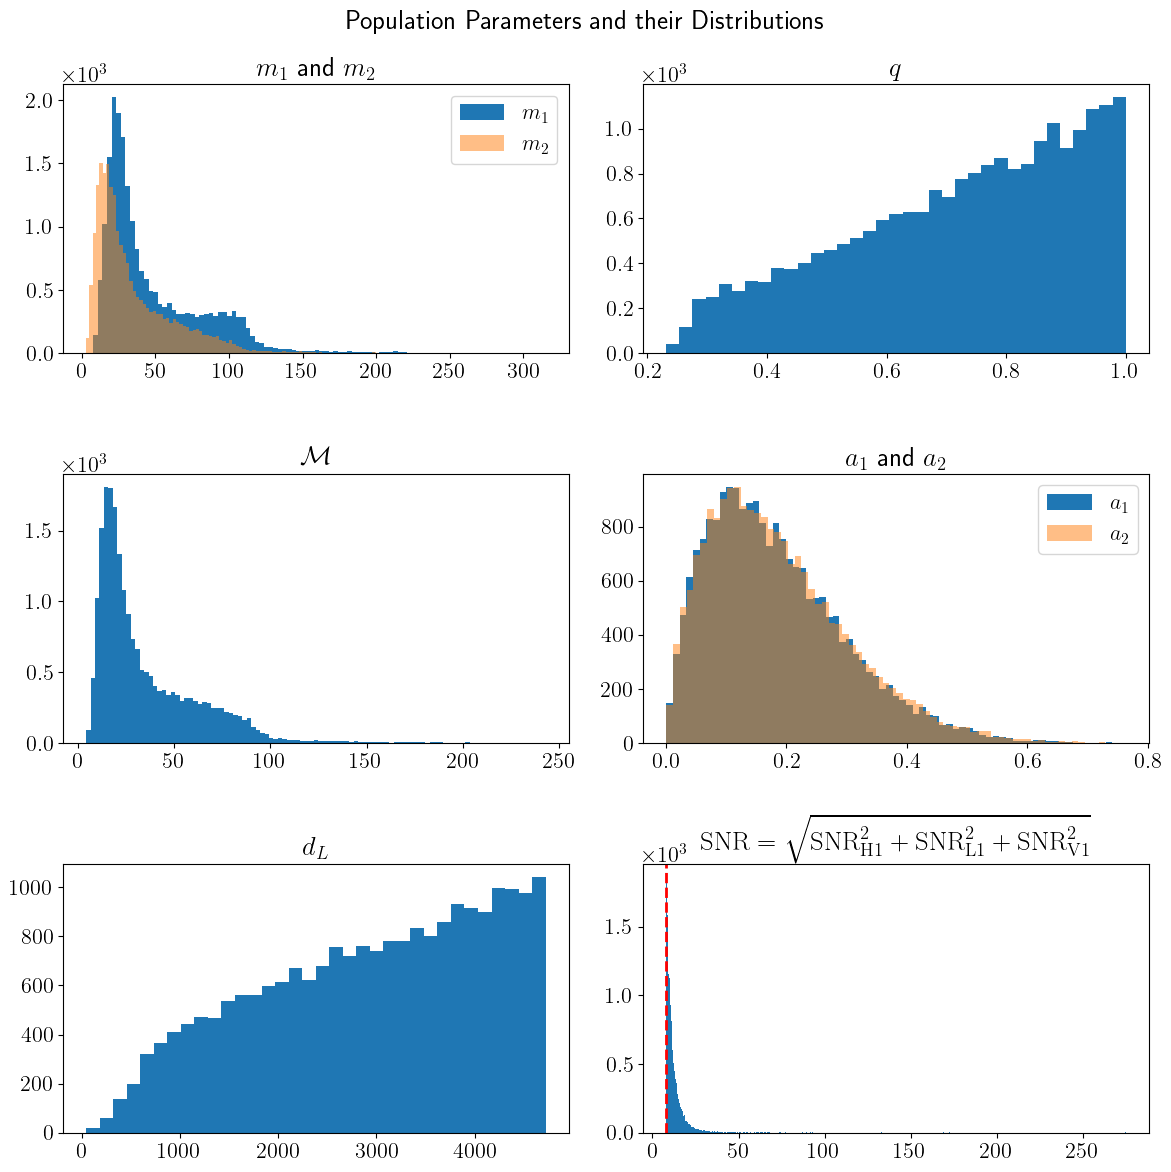

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].hist(mass_1[det_idx], bins='auto', label='$m_1$')
axs[0, 0].hist(mass_2[det_idx], bins='auto', label='$m_2$', alpha=0.5)
axs[0, 0].set_title('$m_1$ and $m_2$')
axs[0, 0].legend()

axs[0, 1].hist(mass_ratio[det_idx], bins='auto')
axs[0, 1].set_title('$q$')

axs[1, 0].hist(mchirp[det_idx], bins='auto')
axs[1, 0].set_title('$\\mathcal{M}$')

axs[1, 1].hist(a_1[det_idx], bins='auto', label='$a_1$')
axs[1, 1].hist(a_2[det_idx], bins='auto', label='$a_2$', alpha=0.5)
axs[1, 1].set_title('$a_1$ and $a_2$')
axs[1, 1].legend()

axs[2, 0].hist(luminosity_distance[det_idx], bins='auto')
axs[2, 0].set_title('$d_L$')
axs[2, 0].ticklabel_format(useOffset=False, style='plain')

axs[2, 1].hist(snr_det, bins='auto')
axs[2, 1].set_title('$\\mathrm{SNR}=\\sqrt{\\mathrm{SNR}_{\\mathrm{H1}}^2+\\mathrm{SNR}_{\\mathrm{L1}}^2+\\mathrm{SNR}_{\\mathrm{V1}}^2}$')
axs[2, 1].axvline(8, linewidth=2, ls='--', color='r')

plt.suptitle('Population Parameters and their Distributions')

fig.tight_layout()
plt.show()

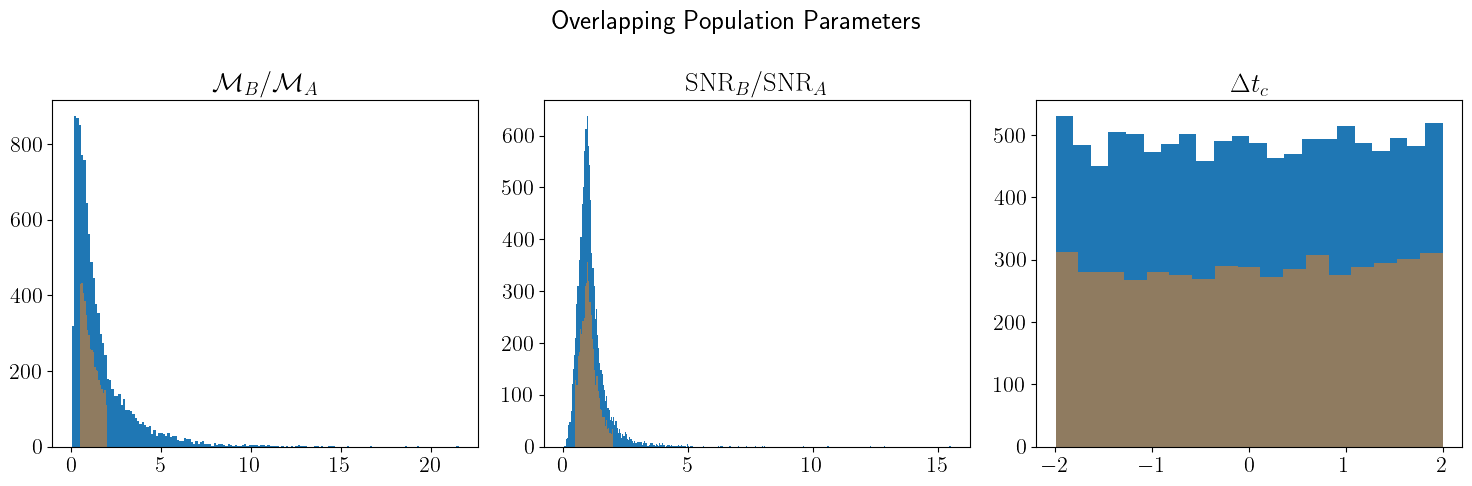

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(mchirpratio, bins='auto')
axs[0].hist(mchirpratio_cut, bins='auto', label='Cut', alpha=0.5)
axs[0].set_title('$\\mathcal{M}_B/\\mathcal{M}_A$')

axs[1].hist(snrratio, bins='auto')
axs[1].hist(snrratio_cut, bins='auto', label='Cut', alpha=0.5)
axs[1].set_title('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')

axs[2].hist(delta_tc, bins='auto')
axs[2].hist(delta_tc_cut, bins='auto', label='Cut', alpha=0.5)
axs[2].set_title('$\\Delta t_c$')

plt.suptitle('Overlapping Population Parameters')

fig.tight_layout()
plt.show()

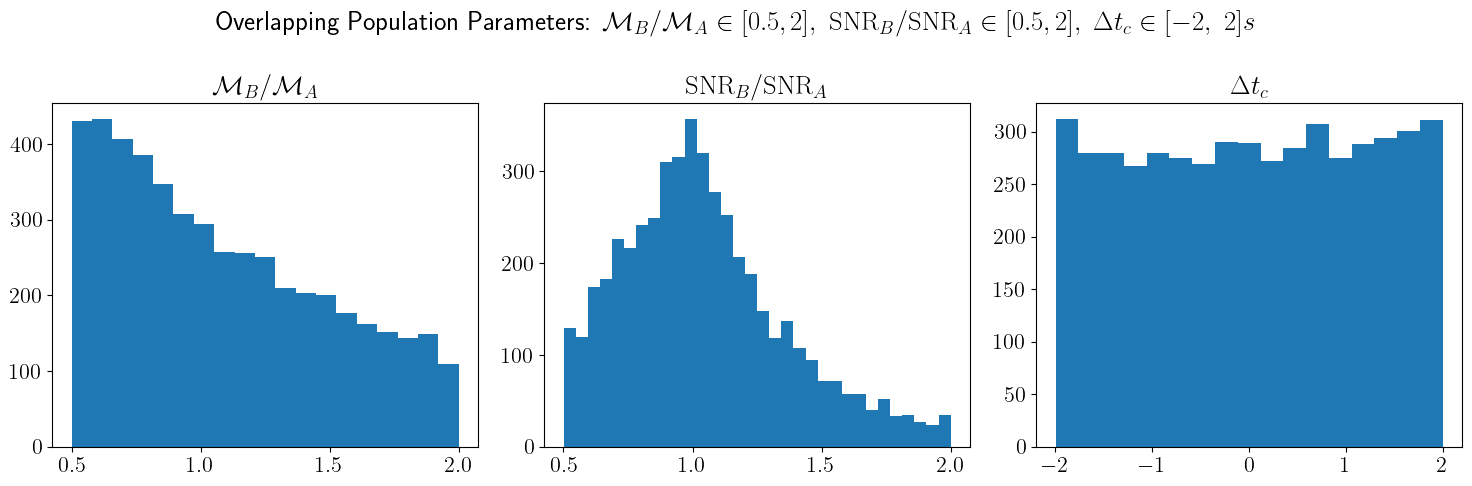

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(mchirpratio_cut, bins='auto')
axs[0].set_title('$\\mathcal{M}_B/\\mathcal{M}_A$')

axs[1].hist(snrratio_cut, bins='auto')
axs[1].set_title('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')

axs[2].hist(delta_tc_cut, bins='auto')
axs[2].set_title('$\\Delta t_c$')

plt.suptitle('Overlapping Population Parameters: $\\mathcal{M}_B/\\mathcal{M}_A\\in[0.5,2], \ \\mathrm{SNR}_B/\\mathrm{SNR}_A\\in[0.5,2], \ \\Delta t_c\\in[-2,\ 2]s$')

fig.tight_layout()
plt.show()

In [8]:
idx = np.random.choice(det_idx, 2, replace = False) 

injection_parameters_a = {}
for key, val in injection.items():
    injection_parameters_a[key] = val[idx[0]]   # Updating the variables

injection_parameters_b = {}
for key, val in injection.items():
    injection_parameters_b[key] = val[idx[1]]   # Updating the variables
injection_parameters_b['geocent_time'] += np.random.uniform(0,0.5)   # Strong Bias

start_time = injection_parameters_a['geocent_time']-duration+2

# Bilby's WaveformGenerator object to generate BBH waveforms

waveform_generator_a = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

waveform_generator_b = bilby.gw.WaveformGenerator(duration=duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

# Initializing the detectors as bilby interferometer objects with zero noise, and with GPS time around the geocenter time of the GW signal

ifos, ifos_a, ifos_b = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initialize Detectors

20:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [9]:
for det in [ifos, ifos_a, ifos_b]:
    for ifo in det:
        ifo.minimum_frequency, ifo.maximum_frequency  = minimum_frequency, sampling_frequency/2
    det.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = start_time)

# Injecting the SINGLES GW signal into H1, L1, and V1 using bilby, and saving the parameters

ifos_a.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # SINGLES A
with open('../../output/injections/Waveform A Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_a.meta_data, file) 

ifos_b.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # SINGLES B
with open('../../output/injections/Waveform B Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_b.meta_data, file)

20:48 bilby INFO    : Injected signal in H1:
20:48 bilby INFO    :   optimal SNR = 3.17
20:48 bilby INFO    :   matched filter SNR = 3.17+0.00j
20:48 bilby INFO    :   mass_1_source = 33.595419258695934
20:48 bilby INFO    :   mass_ratio = 0.5189036273623989
20:48 bilby INFO    :   a_1 = 0.16879247166491845
20:48 bilby INFO    :   a_2 = 0.5491052347032437
20:48 bilby INFO    :   redshift = 2.178246415178968
20:48 bilby INFO    :   cos_tilt_1 = 0.33506570963097176
20:48 bilby INFO    :   cos_tilt_2 = -0.8828363773083909
20:48 bilby INFO    :   phi_12 = 3.0349794767918814
20:48 bilby INFO    :   phi_jl = 4.662618497452913
20:48 bilby INFO    :   cos_theta_jn = -0.43017000141476847
20:48 bilby INFO    :   ra = 1.6078338393077622
20:48 bilby INFO    :   dec = 0.9165312849763438
20:48 bilby INFO    :   psi = 2.6225179860620997
20:48 bilby INFO    :   phase = 5.138492330372333
20:48 bilby INFO    :   incl = 1.0122227290404786
20:48 bilby INFO    :   cos_theta_zn = 0.6886885942835543
20:48 bi

In [10]:
ifos.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # PAIRS (A)
ifos.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # PAIRS (B)

# Extrapolating the strain data in the time domain

H1_strain_a, L1_strain_a, V1_strain_a = ifos_a[0].time_domain_strain, ifos_a[1].time_domain_strain, ifos_a[2].time_domain_strain    # SINGLES A
H1_strain_b, L1_strain_b, V1_strain_b = ifos_b[0].time_domain_strain, ifos_b[1].time_domain_strain, ifos_b[2].time_domain_strain    # SINGLES B
H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain    # PAIRS

# Generating PyCBC TimeSeries from the strain array

ht_a_H1, ht_a_L1, ht_a_V1 = pycbc.types.TimeSeries(H1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_a, delta_t = 1/sampling_frequency)    # SINGLES A
ht_b_H1, ht_b_L1, ht_b_V1 = pycbc.types.TimeSeries(H1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_b, delta_t = 1/sampling_frequency)    # SINGLES B
ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)    # PAIRS

# Setting the start times to the geocenter time and creating the dictionary of waveforms 

ht_a_H1.start_time, ht_a_L1.start_time, ht_a_V1.start_time = start_time, start_time, start_time    # SINGLES A
ht_b_H1.start_time, ht_b_L1.start_time, ht_b_V1.start_time = start_time, start_time, start_time    # SINGLES B
ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = start_time, start_time, start_time    # PAIRS

ht_a, ht_b, ht = {'H1': ht_a_H1, 'L1': ht_a_L1, 'V1': ht_a_V1}, {'H1': ht_b_H1, 'L1': ht_b_L1, 'V1': ht_b_V1}, {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

20:48 bilby INFO    : Injected signal in H1:
20:48 bilby INFO    :   optimal SNR = 3.17
20:48 bilby INFO    :   matched filter SNR = 3.17+0.00j
20:48 bilby INFO    :   mass_1_source = 33.595419258695934
20:48 bilby INFO    :   mass_ratio = 0.5189036273623989
20:48 bilby INFO    :   a_1 = 0.16879247166491845
20:48 bilby INFO    :   a_2 = 0.5491052347032437
20:48 bilby INFO    :   redshift = 2.178246415178968
20:48 bilby INFO    :   cos_tilt_1 = 0.33506570963097176
20:48 bilby INFO    :   cos_tilt_2 = -0.8828363773083909
20:48 bilby INFO    :   phi_12 = 3.0349794767918814
20:48 bilby INFO    :   phi_jl = 4.662618497452913
20:48 bilby INFO    :   cos_theta_jn = -0.43017000141476847
20:48 bilby INFO    :   ra = 1.6078338393077622
20:48 bilby INFO    :   dec = 0.9165312849763438
20:48 bilby INFO    :   psi = 2.6225179860620997
20:48 bilby INFO    :   phase = 5.138492330372333
20:48 bilby INFO    :   incl = 1.0122227290404786
20:48 bilby INFO    :   cos_theta_zn = 0.6886885942835543
20:48 bi

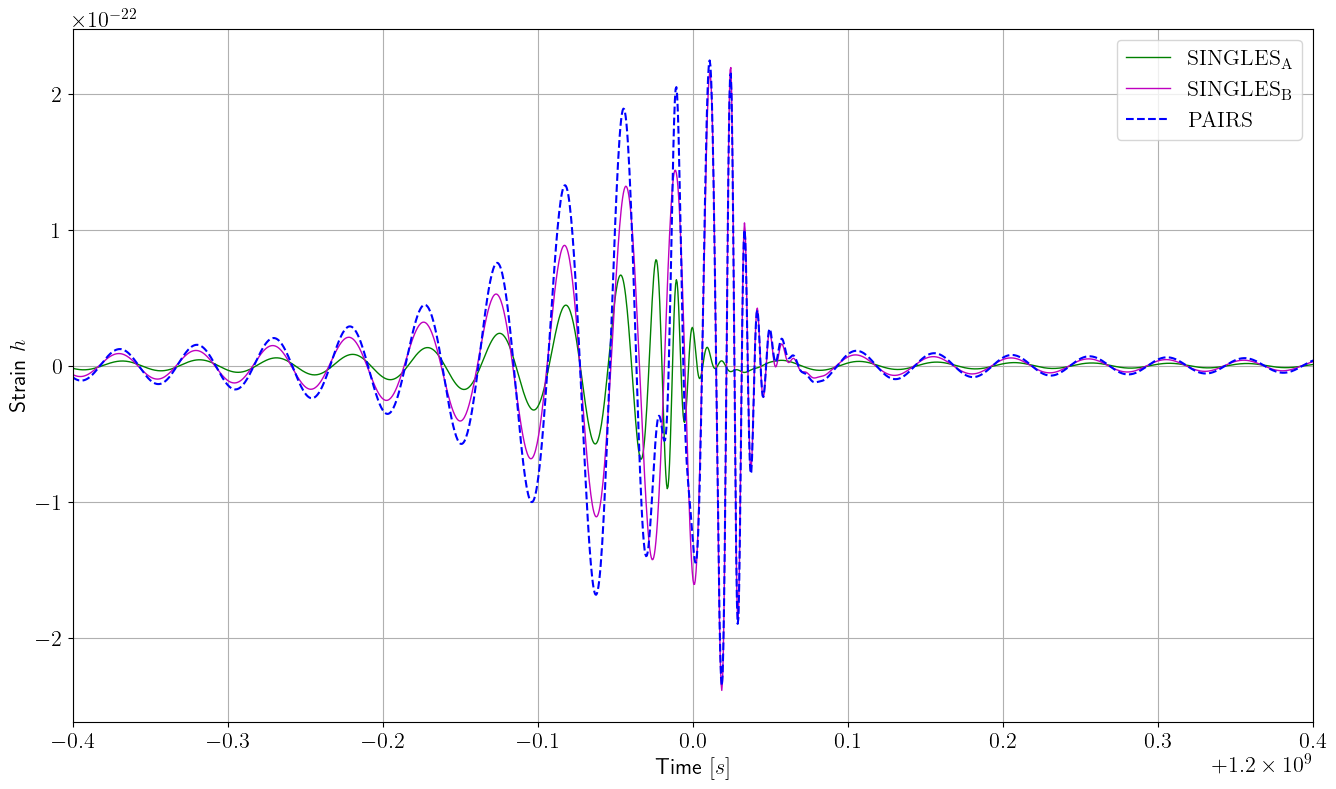

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(ht_a['H1'].sample_times, ht_a['H1'], 'g-', linewidth=1, label='$\\rm{SINGLES_A}$')
ax.plot(ht_b['H1'].sample_times, ht_b['H1'], 'm-', linewidth=1, label='$\\rm{SINGLES_B}$')
ax.plot(ht['H1'].sample_times, ht['H1'], 'b--', label='$\\rm{PAIRS}$')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(start_time+duration-2.4, start_time+duration-1.6)
ax.legend()
ax.grid(True)
plt.show()